In [ ]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.0.1+cu118


In [ ]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [ ]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images

        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']

        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)

        self.image_dirs = image_dirs
        self.transform = transform


    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])


    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_dirs = {
    'normal': '/content/drive/MyDrive/NORMAL',
    'viral': '/content/drive/MyDrive/NORMAL',
    'covid': '/content/drive/MyDrive/COVID-19'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1342 normal examples
Found 1342 viral examples
Found 1143 covid examples


In [ ]:
test_dirs = {
    'normal': '/content/drive/MyDrive/NORMAL',
    'viral': '/content/drive/MyDrive/NORMAL',
    'covid': '/content/drive/MyDrive/COVID-19'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 1342 normal examples
Found 1342 viral examples
Found 1143 covid examples


In [ ]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 638
Number of test batches 638


In [ ]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

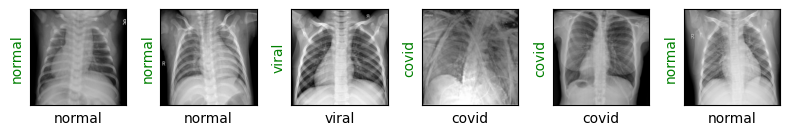

In [ ]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

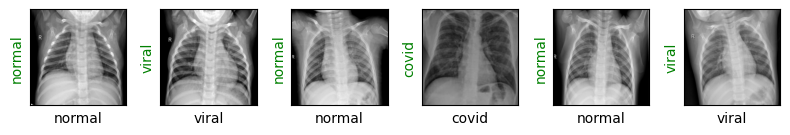

In [ ]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 279MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [ ]:
def show_preds():
    resnet18.eval() # set to evaluation mode
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

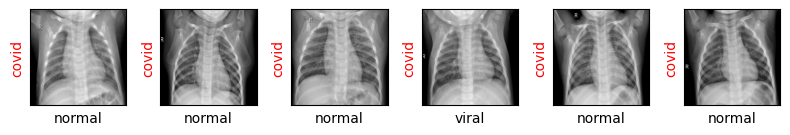

In [ ]:
show_preds()

In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.3609, Accuracy: 0.3240


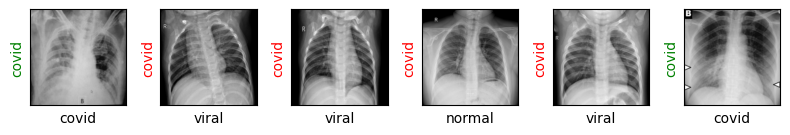

Evaluating at step 20
Validation Loss: 0.7271, Accuracy: 0.6399


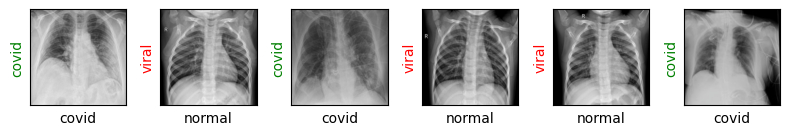

Evaluating at step 40
Validation Loss: 0.6264, Accuracy: 0.6577


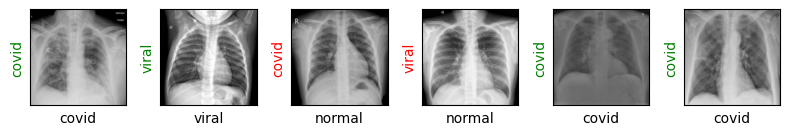

Evaluating at step 60
Validation Loss: 0.5791, Accuracy: 0.6783


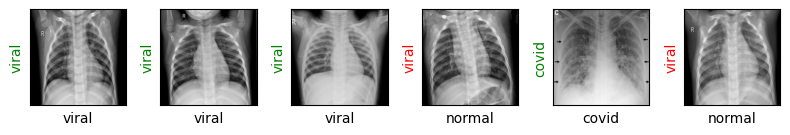

Evaluating at step 80
Validation Loss: 0.5852, Accuracy: 0.6653


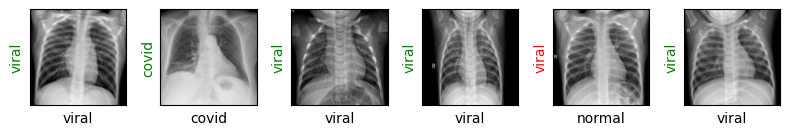

Evaluating at step 100
Validation Loss: 0.5323, Accuracy: 0.6642


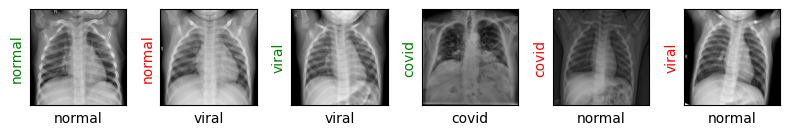

Evaluating at step 120
Validation Loss: 0.6295, Accuracy: 0.6415


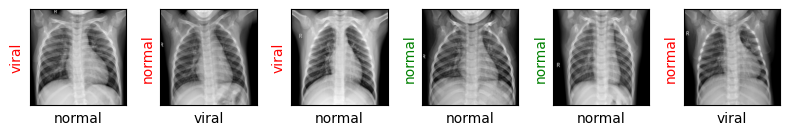

Evaluating at step 140
Validation Loss: 0.5448, Accuracy: 0.6517


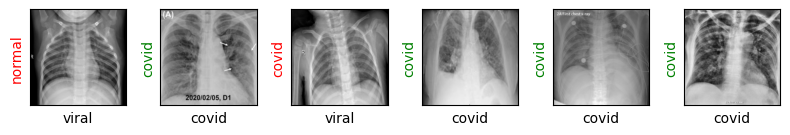

Evaluating at step 160
Validation Loss: 0.5109, Accuracy: 0.6634


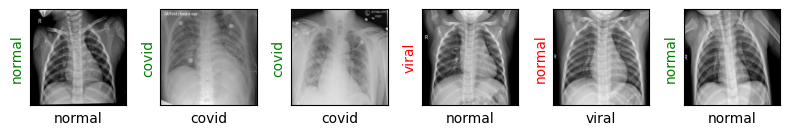

Evaluating at step 180
Validation Loss: 0.5067, Accuracy: 0.6708


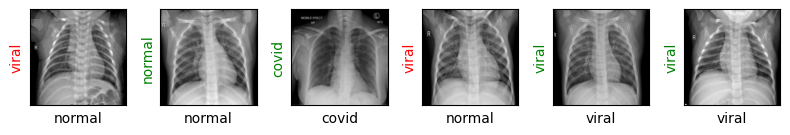

Evaluating at step 200
Validation Loss: 0.5056, Accuracy: 0.6637


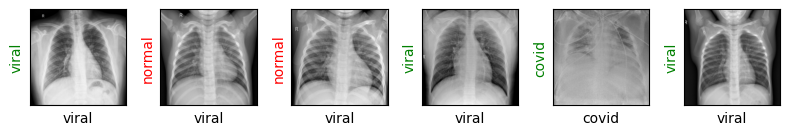

Evaluating at step 220
Validation Loss: 0.5164, Accuracy: 0.6543


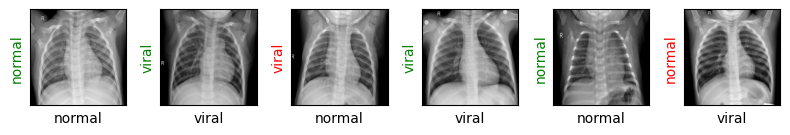

Evaluating at step 240
Validation Loss: 0.5096, Accuracy: 0.6621


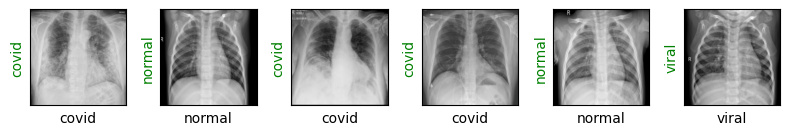

Evaluating at step 260
Validation Loss: 0.5099, Accuracy: 0.6533


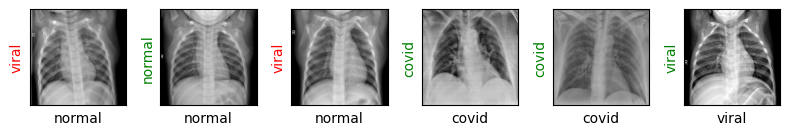

Evaluating at step 280
Validation Loss: 0.5284, Accuracy: 0.6454


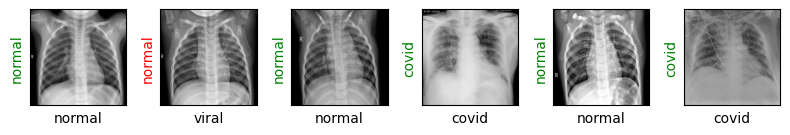

Evaluating at step 300
Validation Loss: 0.5147, Accuracy: 0.6648


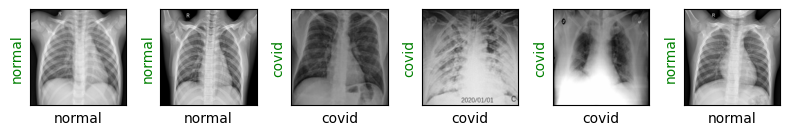

Evaluating at step 320
Validation Loss: 0.5460, Accuracy: 0.6506


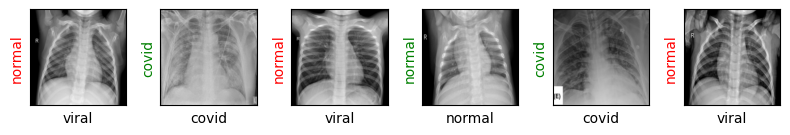

Evaluating at step 340
Validation Loss: 0.5601, Accuracy: 0.6658


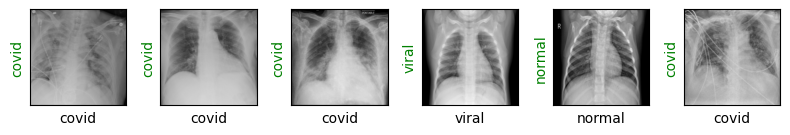

Evaluating at step 360
Validation Loss: 0.5147, Accuracy: 0.6593


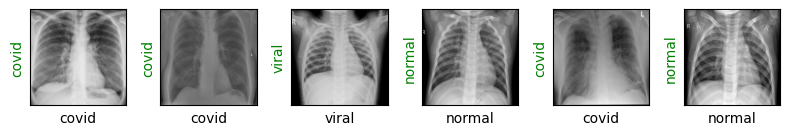

Evaluating at step 380
Validation Loss: 0.5064, Accuracy: 0.6726


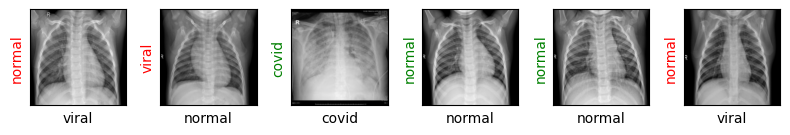

Evaluating at step 400
Validation Loss: 0.5127, Accuracy: 0.6585


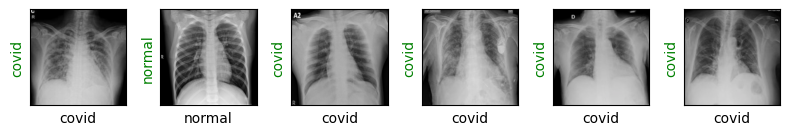

Evaluating at step 420
Validation Loss: 0.4973, Accuracy: 0.6619


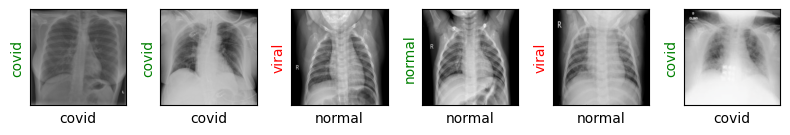

Evaluating at step 440
Validation Loss: 0.5046, Accuracy: 0.6611


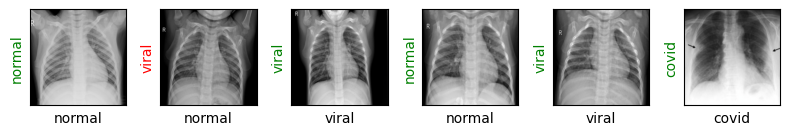

Evaluating at step 460
Validation Loss: 0.5028, Accuracy: 0.6723


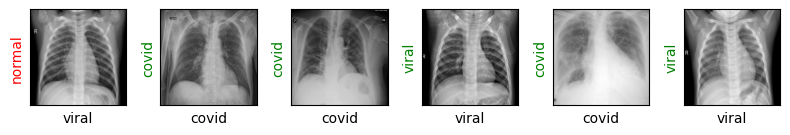

Evaluating at step 480
Validation Loss: 0.4928, Accuracy: 0.6736


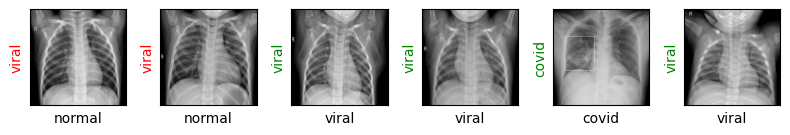

Evaluating at step 500
Validation Loss: 0.5011, Accuracy: 0.6629


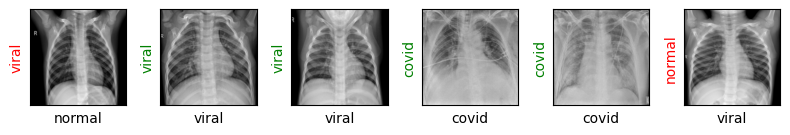

Evaluating at step 520
Validation Loss: 0.5204, Accuracy: 0.6674


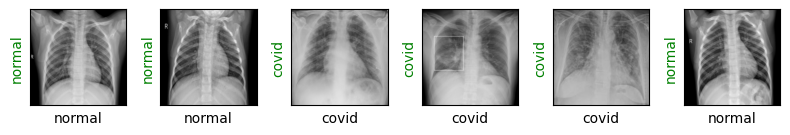

Evaluating at step 540
Validation Loss: 0.4965, Accuracy: 0.6718


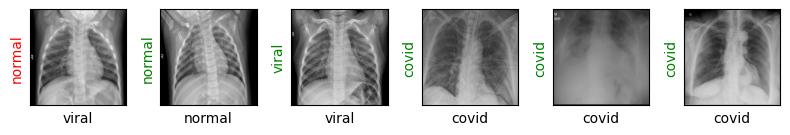

Evaluating at step 560
Validation Loss: 0.5092, Accuracy: 0.6616


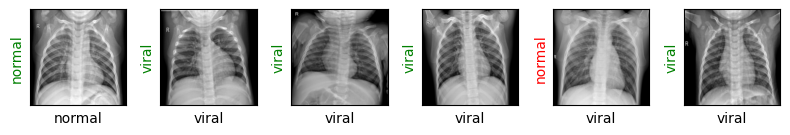

Evaluating at step 580
Validation Loss: 0.4911, Accuracy: 0.6718


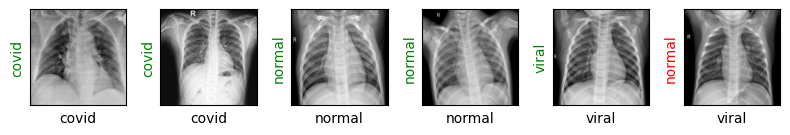

Evaluating at step 600
Validation Loss: 0.5027, Accuracy: 0.6606


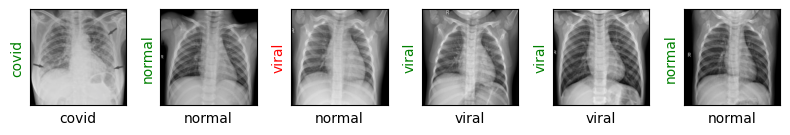

Evaluating at step 620
Validation Loss: 0.4876, Accuracy: 0.6718


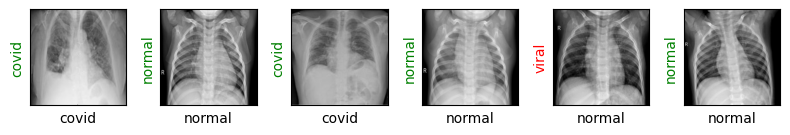

Training Loss: 0.6001
Training complete..
CPU times: user 2h 35min 38s, sys: 1min 56s, total: 2h 37min 35s
Wall time: 2h 53min 4s


In [ ]:
%%time

train(epochs=1)

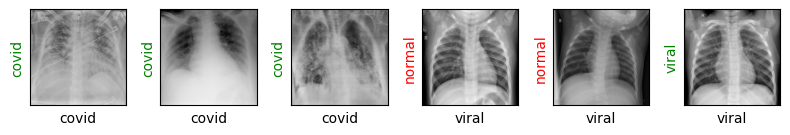

In [ ]:
show_preds()